In [1]:
import numpy as np
import scipy.io as sio
import torch

import scipy.io as sio
import torch
from spenpy.spen import spen

import matplotlib.pyplot as plt

class physical_model:
    def __init__(self, img_size=(96, 96)):
        self.InvA, self.AFinal = spen(acq_point=img_size).get_InvA()
    
    def __call__(self, x, phase_map=None):
        x = torch.matmul(self.AFinal * 1j, x)
        if phase_map is not None:
            x[:, 1::2, :] *= torch.exp(1j * phase_map)
        return x
    
    def recons(self, x, phase_map=None):
        if phase_map is not None:
            x[:, 1::2, :] *= torch.exp(-1j * phase_map)
        return torch.matmul(self.InvA, x)
    
    
def get_demo(data_root="/home/data1/musong/workspace/2025/8/08-20/tr/data/IXI_sim", 
             id="IXI050-Guys-0711-T1_idx0004.mat",
             if_phase_map=False):
    PM = physical_model()
    if(if_phase_map):
        phase_map = sio.loadmat(f"{data_root}/phase_map/{id}")
        phase_map = phase_map[next(reversed(phase_map.keys()))]
        phase_map = torch.tensor(phase_map, dtype=torch.complex64).unsqueeze(0)
    
    data = sio.loadmat(f"{data_root}/data/{id}")
    data = data[next(reversed(data.keys()))]
    data = torch.tensor(data, dtype=torch.complex64).unsqueeze(0)

    if if_phase_map:
        lr = PM(data, phase_map=phase_map)  
        recons = PM.recons(lr, phase_map=phase_map)
    else:
        lr = PM(data)
        recons = PM.recons(lr)
    
    return data, lr, recons

In [2]:
rat_data = sio.loadmat("/home/data1/musong/workspace/2025/8/08-20/nxz/real_data/rat/RAT_train_1000_org.mat")
print(rat_data.keys())

dict_keys(['__header__', '__version__', '__globals__', 'AFinal', 'AWhole', 'ImagAll', 'blur', 'deBlur'])


In [3]:
PM = physical_model()
res_data = PM.recons(torch.tensor(rat_data['blur'][0]))

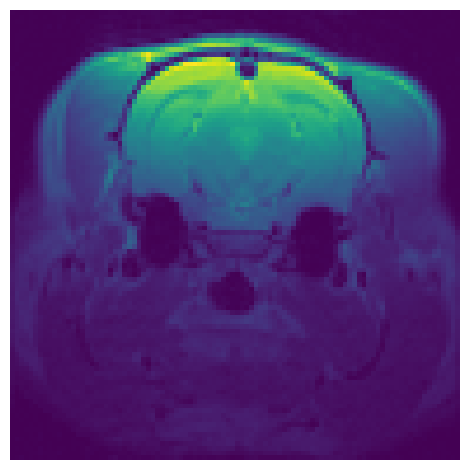

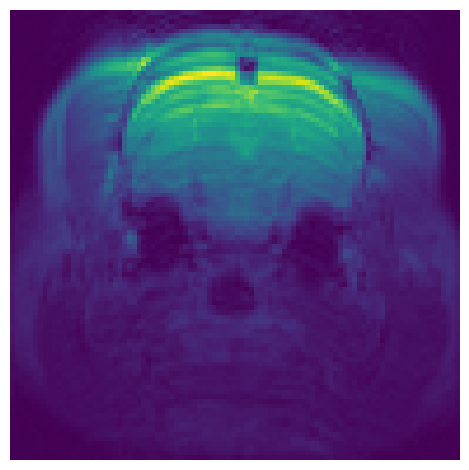

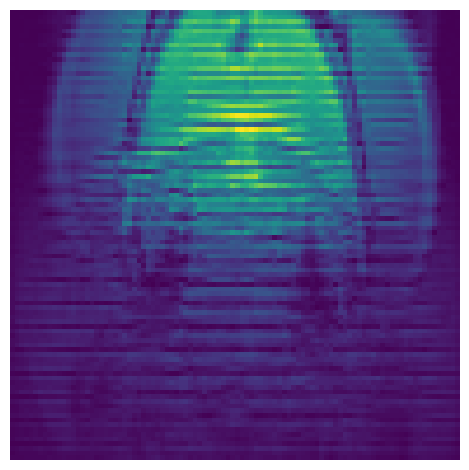

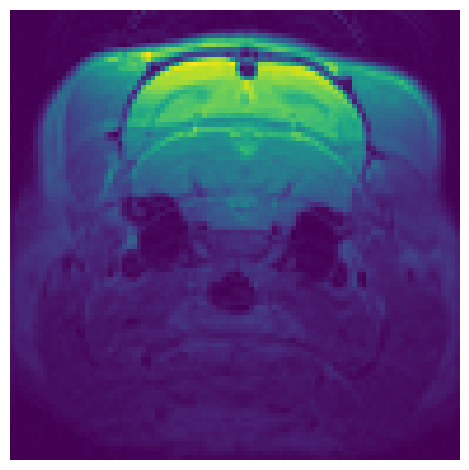

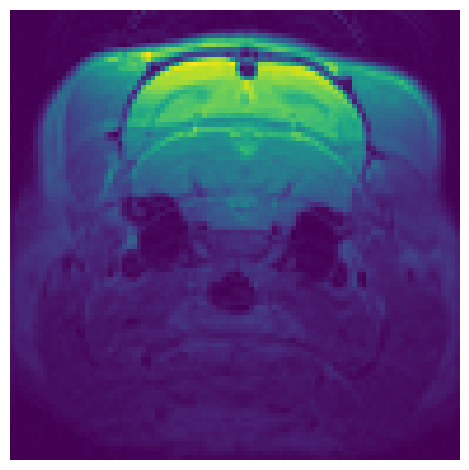

In [8]:
idx = 10

plt.figure()
plt.imshow(np.abs(rat_data['ImagAll'][idx]))
plt.axis("off")
plt.tight_layout()

plt.figure()
plt.imshow(np.abs(rat_data['blur'][idx]))
plt.axis("off")
plt.tight_layout()

plt.figure()
plt.imshow(res_data.abs().numpy())
plt.axis("off")
plt.tight_layout()

plt.figure()
plt.imshow(np.abs(rat_data['AWhole']@rat_data['blur'][idx]))
plt.axis("off")
plt.tight_layout()

plt.figure()
plt.imshow(np.abs(rat_data['deBlur'][idx]))
plt.axis("off")
plt.tight_layout()

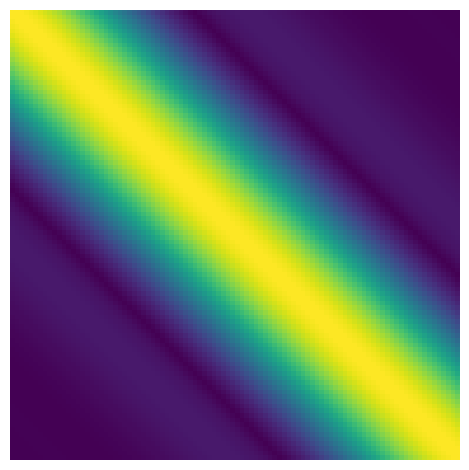

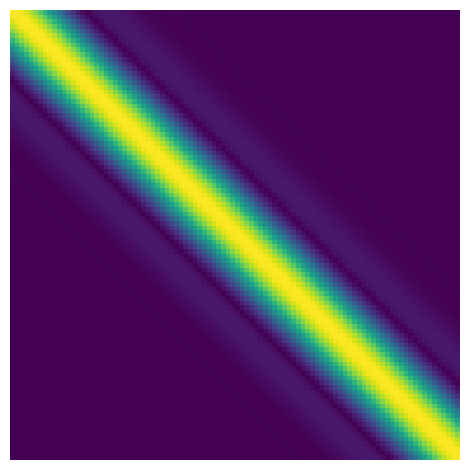

In [9]:
plt.figure()
plt.imshow(np.abs(PM.InvA.resolve_conj().numpy()))
plt.axis("off")
plt.tight_layout()

plt.figure()
plt.imshow(np.abs(rat_data['AWhole']))
plt.axis("off")
plt.tight_layout()